4 6 3 6 3 6 6 5 3

In [1]:
import pandas as pd
import seaborn as sns
import regex as re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from stop_words import get_stop_words
import networkx as nx
from pyvis.network import Network
import numpy as np
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_excel('steam reviews.xlsx')
df.head()

Unnamed: 0                  Author  \
0           0                 Kaladin   
1           1                    KEVE   
2           2            ⛧ M♱ropele ⛧   
3           3  to infinity and beyond   
4           4      chelovek bez vkusa   

                                              Review  # of Comments  \
0  2 10 dollar battle passes per season\n\nTitanf...              0   
1  Now with the new battle pass system, I'm delet...             78   
2  At least you don't have to build an apartment ...             54   
3                       Finally I can remove Origin.              0   
4  Finally here\n\nIt launches without Origin...\...             35   

                  Products       Hours on Account           Remark  \
0  228 products in account      4.1 hrs on record  Not Recommended   
1   42 products in account  1,865.6 hrs on record  Not Recommended   
2  655 products in account      9.6 hrs on record      Recommended   
3  Few products in account      1.1 hrs on record      Recommended   
4  295 products in account     16.6 hrs on record      Recommended   

   Users found review funny  Users found review helpful  Community Awards  
0                       133                        3796               178  
1                        85                        4370               186  
2                      2017                        3089               500  
3                       634                        1770               103  
4                        91                        2109                49

In [3]:
df = df.drop('Unnamed: 0', axis = 1, errors = 'ignore')
df.head()

Author                                             Review  \
0                 Kaladin  2 10 dollar battle passes per season\n\nTitanf...   
1                    KEVE  Now with the new battle pass system, I'm delet...   
2            ⛧ M♱ropele ⛧  At least you don't have to build an apartment ...   
3  to infinity and beyond                       Finally I can remove Origin.   
4      chelovek bez vkusa  Finally here\n\nIt launches without Origin...\...   

   # of Comments                 Products       Hours on Account  \
0              0  228 products in account      4.1 hrs on record   
1             78   42 products in account  1,865.6 hrs on record   
2             54  655 products in account      9.6 hrs on record   
3              0  Few products in account      1.1 hrs on record   
4             35  295 products in account     16.6 hrs on record   

            Remark  Users found review funny  Users found review helpful  \
0  Not Recommended                       133                        3796   
1  Not Recommended                        85                        4370   
2      Recommended                      2017                        3089   
3      Recommended                       634                        1770   
4      Recommended                        91                        2109   

   Community Awards  
0               178  
1               186  
2               500  
3               103  
4                49

In [4]:
df_new = df.copy()

In [5]:
df_new['Products'] = (
    df.Products.str.replace(r'\D','', regex = True)
    .map(lambda x: 0 if x == '' else x)
    .astype(int)
)
df_new['Hours on Account'] = (
    df['Hours on Account'].str.replace(r'\D','',regex=True)
    .map(lambda x: 0 if x == '' else x)
    .astype(int)
)

df_new.head()

Author                                             Review  \
0                 Kaladin  2 10 dollar battle passes per season\n\nTitanf...   
1                    KEVE  Now with the new battle pass system, I'm delet...   
2            ⛧ M♱ropele ⛧  At least you don't have to build an apartment ...   
3  to infinity and beyond                       Finally I can remove Origin.   
4      chelovek bez vkusa  Finally here\n\nIt launches without Origin...\...   

   # of Comments  Products  Hours on Account           Remark  \
0              0       228                41  Not Recommended   
1             78        42             18656  Not Recommended   
2             54       655                96      Recommended   
3              0         0                11      Recommended   
4             35       295               166      Recommended   

   Users found review funny  Users found review helpful  Community Awards  
0                       133                        3796               178  
1                        85                        4370               186  
2                      2017                        3089               500  
3                       634                        1770               103  
4                        91                        2109                49

In [6]:
df_new['Remark'].unique()

array(['Not Recommended', 'Recommended'], dtype=object)

In [7]:
df_new['Remark'] = df_new.Remark.map({'Not Recommended':0,'Recommended':1})
df_new = df_new.rename({'Remark':'isRecommended'}, axis = 1)
df_new

Author  \
0                   Kaladin   
1                      KEVE   
2              ⛧ M♱ropele ⛧   
3    to infinity and beyond   
4        chelovek bez vkusa   
..                      ...   
995          Mayano Top Gun   
996                  Dubinn   
997                   Fiery   
998                 ZenTrix   
999                    BOOF   

                                                Review  # of Comments  \
0    2 10 dollar battle passes per season\n\nTitanf...              0   
1    Now with the new battle pass system, I'm delet...             78   
2    At least you don't have to build an apartment ...             54   
3                         Finally I can remove Origin.              0   
4    Finally here\n\nIt launches without Origin...\...             35   
..                                                 ...            ...   
995                                       GAME NGENTOD              0   
996  Used to love it, now look at what they did to ...              0   
997  You removed linux support? AI cheats basically...              0   
998  You accidentally fall off a cliff while trying...              0   
999  This game gave me:\n\n· Acne\n· AIDS\n· Allerg...              0   

     Products  Hours on Account  isRecommended  Users found review funny  \
0         228                41              0                       133   
1          42             18656              0                        85   
2         655                96              1                      2017   
3           0                11              1                       634   
4         295               166              1                        91   
..        ...               ...            ...                       ...   
995        74              8195              0                         1   
996       347              1057              0                         0   
997         0                18              0                         0   
998       162              3316              1                         0   
999         0                23              0                        13   

     Users found review helpful  Community Awards  
0                          3796               178  
1                          4370               186  
2                          3089               500  
3                          1770               103  
4                          2109                49  
..                          ...               ...  
995                          14                 0  
996                          11                 0  
997                          24                 0  
998                           7                 1  
999                          10                 0  

[1000 rows x 9 columns]

In [8]:
df_new.describe()

# of Comments      Products  Hours on Account  isRecommended  \
count    1000.000000   1000.000000       1000.000000    1000.000000   
mean        4.170000    238.503000       8478.611000       0.558000   
std        16.599537    844.863574      16197.627037       0.496873   
min         0.000000      0.000000          1.000000       0.000000   
25%         0.000000      0.000000        644.500000       0.000000   
50%         0.000000     45.000000       3609.500000       1.000000   
75%         3.000000    205.000000      10376.250000       1.000000   
max       434.000000  16131.000000     241730.000000       1.000000   

       Users found review funny  Users found review helpful  Community Awards  
count               1000.000000                 1000.000000       1000.000000  
mean                  50.336000                  209.777000         17.629000  
std                  135.558457                  400.198041         42.173332  
min                    0.000000                    0.000000          0.000000  
25%                    2.000000                   25.000000          1.000000  
50%                   10.000000                   79.000000          5.000000  
75%                   45.250000                  233.500000         16.000000  
max                 2017.000000                 6142.000000        517.000000

<Axes: >

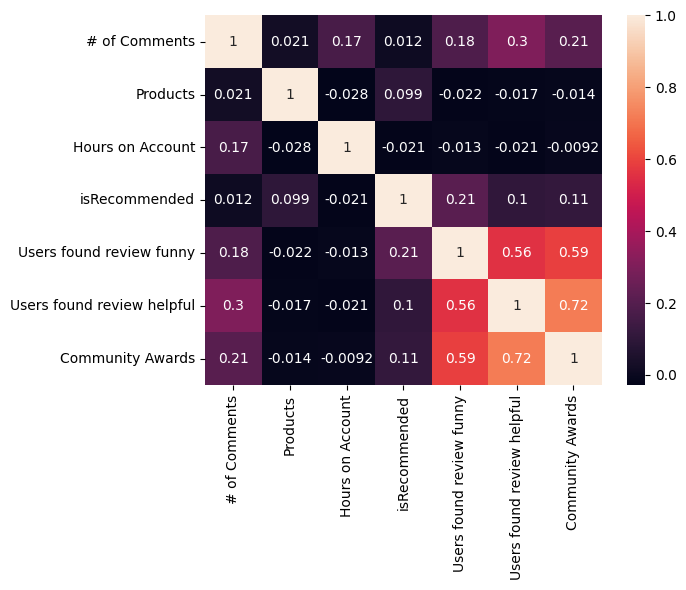

In [9]:
sns.heatmap(df_new.corr(numeric_only=True), annot = True)

# Wordcloud

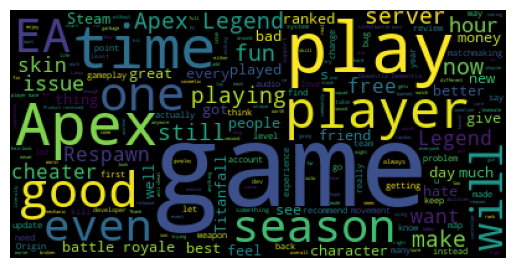

In [10]:
all_reviews = ' '.join(df_new['Review'].str.replace('\n',' ').tolist())

wordcloud = WordCloud().generate_from_text(all_reviews)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [11]:
# Function to make generation easier
def generate_wordcloud(text: str, min_word_length: int = 0) -> None:
    wordcloud = WordCloud(min_word_length=min_word_length).generate_from_text(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    return

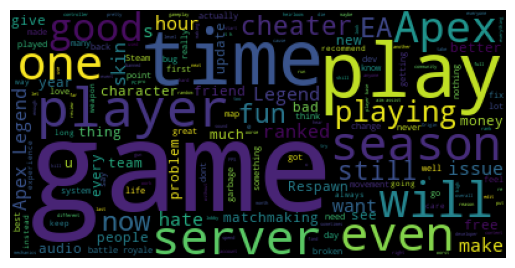

In [12]:
high_hour_reviews = ' '.join(
    df_new[df_new['Hours on Account'] > df_new['Hours on Account'].mean()]['Review']
    .str.replace('\n', ' ').tolist()
    )

generate_wordcloud(high_hour_reviews)

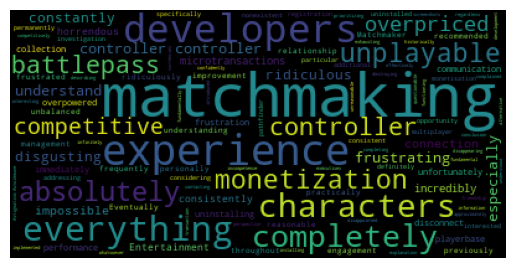

In [13]:
negative_reviews = ' '.join(
    df_new[df_new['isRecommended'] == 0]['Review']
    .str.replace('\n',' ').tolist()
)

# Changing the min_word_length argument filters out some of the common words
generate_wordcloud(negative_reviews, 10)

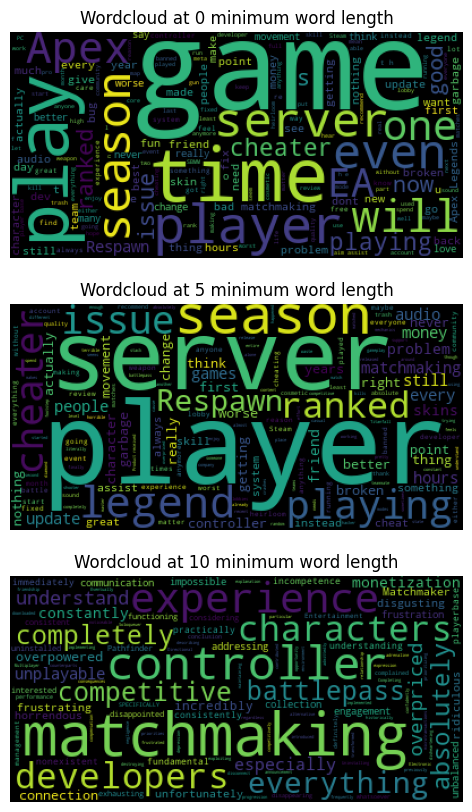

In [14]:
# Generate wordcloud plots in intervals of 5 from 0 to 10
high_hour_negative_reviews = ' '.join(
    df_new[(df_new['Hours on Account'] > df_new['Hours on Account'].mean()) & (df_new['isRecommended'] == 0)]['Review']
    .str.replace('\n',' ').tolist()
)
fig, axs = plt.subplots(3, 1, figsize = (12,10))

for i,v in enumerate([0, 5, 10]):
    wordcloud = WordCloud(min_word_length = v).generate_from_text(high_hour_negative_reviews)
    axs[i].imshow(wordcloud)
    axs[i].set_axis_off()
    axs[i].set_title(f'Wordcloud at {v} minimum word length')

In [15]:
def generate_all_wordclouds(texts: str, start: int = 0, end: int = 10, step: int = 5, 
                            figsize: tuple[int,int] = (15,12)) -> None:
    num_plots = (end - start)//step + 1
    intervals = [i for i in range(start, end + 1, step)]    
    fig, axs = plt.subplots(num_plots, 1, figsize = figsize)
    
    for i,v in enumerate(intervals):
        wordcloud = WordCloud(min_word_length = v).generate_from_text(texts)
        axs[i].imshow(wordcloud)
        axs[i].set_axis_off()
        axs[i].set_title(f'Wordcloud at {v} minimum word length')
        
    return

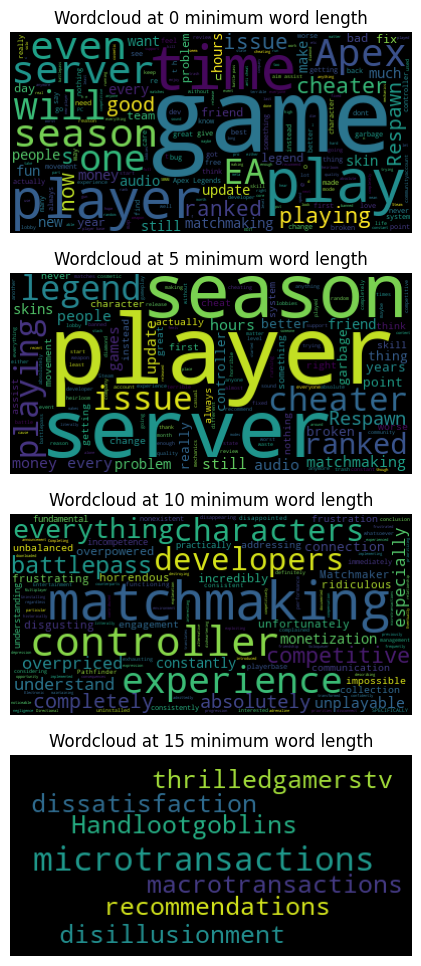

In [16]:
generate_all_wordclouds(high_hour_negative_reviews, end = 15)

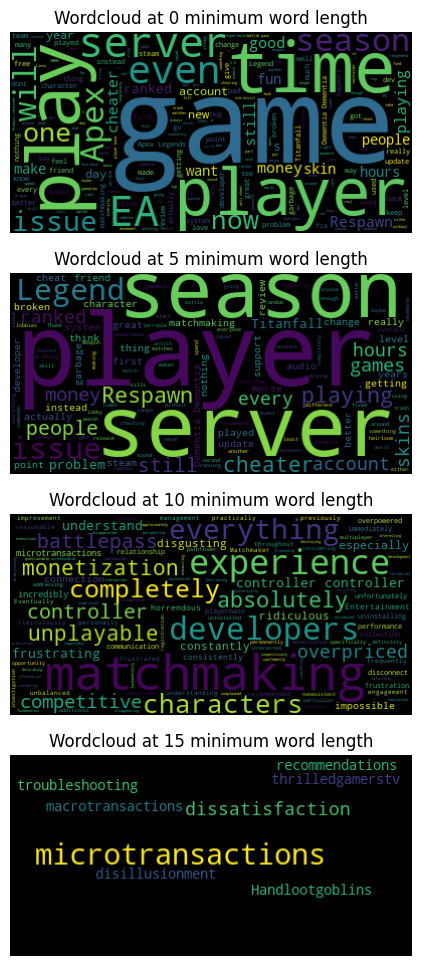

In [17]:
generate_all_wordclouds(negative_reviews, end = 15)

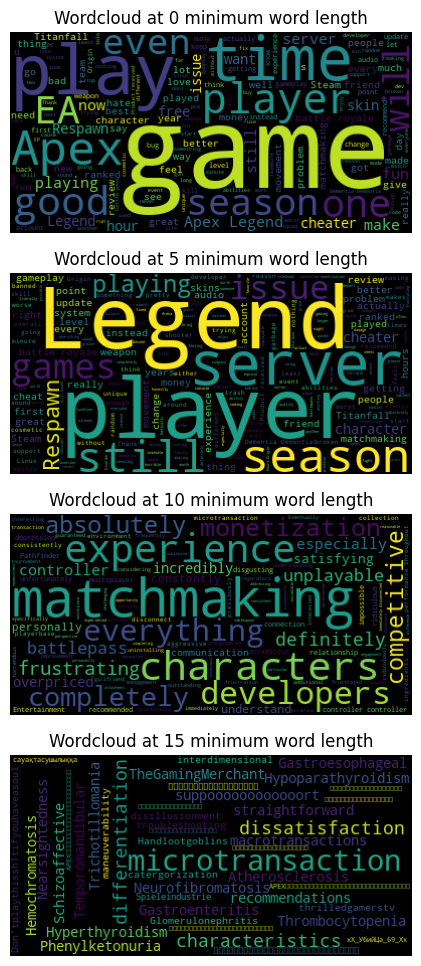

In [18]:
generate_all_wordclouds(all_reviews, end = 15)

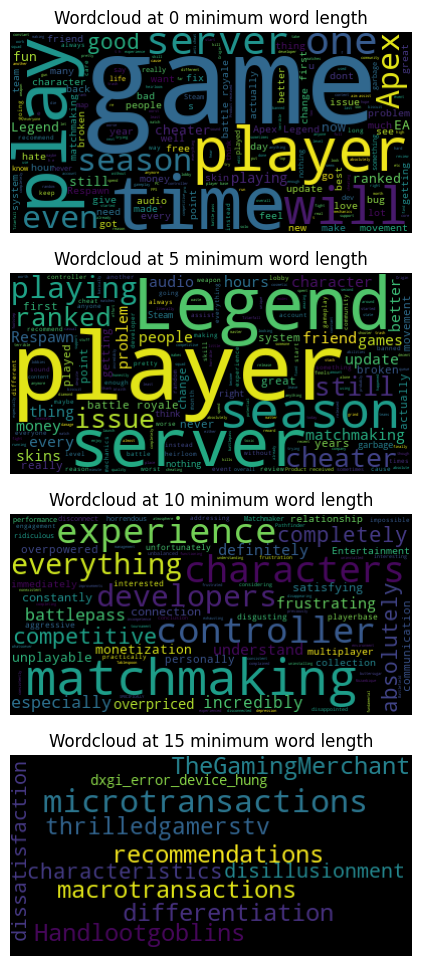

In [19]:
generate_all_wordclouds(high_hour_reviews, end = 15)

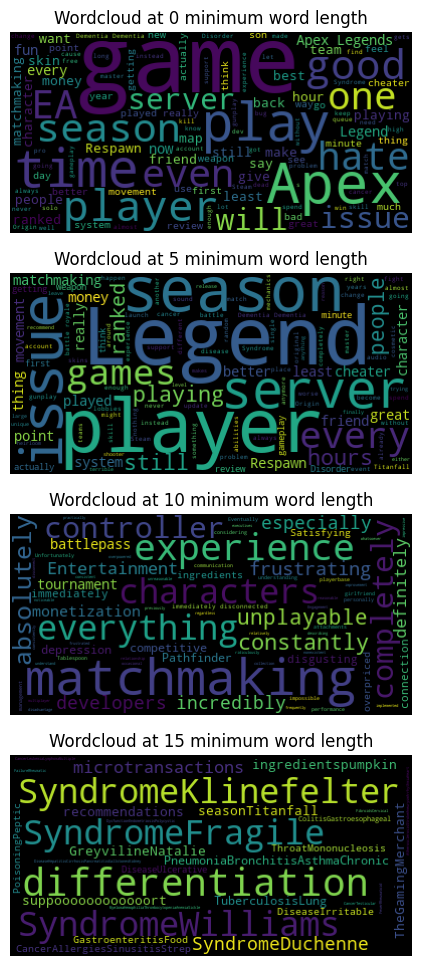

In [20]:
# Filter by helpful
helpful_df = df_new[df_new['Users found review helpful'] > df_new['Users found review helpful'].mean()]

helpful = ' '.join(helpful_df['Review'].str.replace('\n','').tolist())

generate_all_wordclouds(helpful, end = 15)

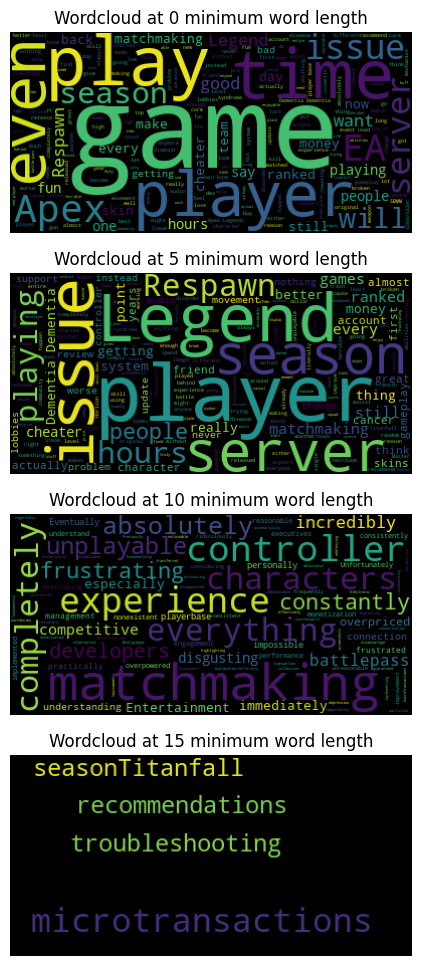

In [21]:
helpful_negative = ' '.join(helpful_df[helpful_df['isRecommended'] == 0]['Review'].str.replace('\n','').tolist())

generate_all_wordclouds(helpful_negative, end = 15)

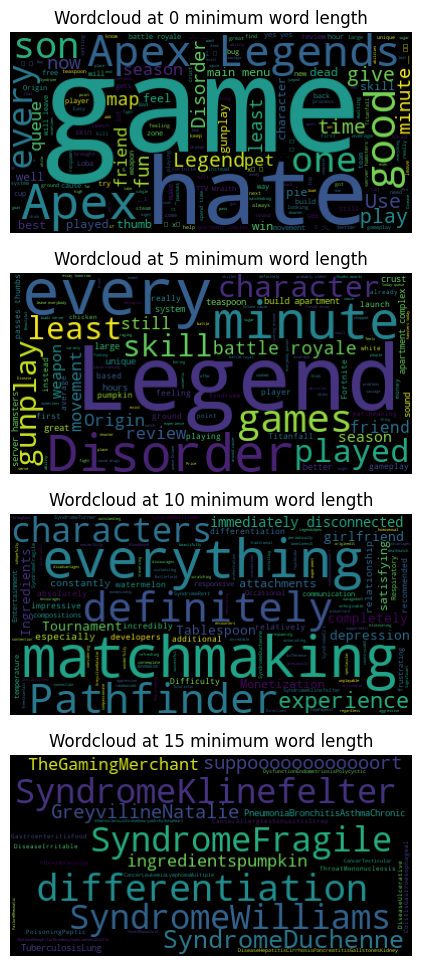

In [22]:
helpful_positive = ' '.join(helpful_df[helpful_df['isRecommended'] == 1]['Review'].str.replace('\n','').tolist())

generate_all_wordclouds(helpful_positive, end = 15)

# Topic Extraction

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [24]:
documents = df_new['Review'].str.replace('\n','').tolist()

tfid = TfidfVectorizer(stop_words = 'english')
document_X = tfid.fit_transform(documents)

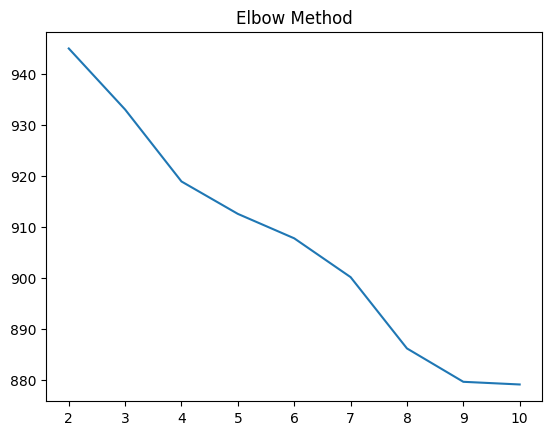

In [25]:
inertias = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = 0, n_init = 10)
    model = kmeans.fit(document_X)
    inertias.append(model.inertia_)
    
plt.plot(range(2,11), inertias)
plt.title('Elbow Method')
plt.show()

In [26]:
kmeans = KMeans(n_clusters = 4, random_state = 0, n_init = 10)
model = kmeans.fit(document_X)

In [27]:
features = tfid.get_feature_names_out()
features

array(['00', '000', '000art', ..., '𝙪𝙨𝙚𝙙', '𝙬𝙖𝙮', '𝙬𝙞𝙩𝙝'],
      shape=(7842,), dtype=object)

In [28]:
model.cluster_centers_[0].argsort()[::-1]

array([3901, 2190, 3865, ...,   20,   19,   53], shape=(7842,))

In [29]:
features[1438]

'complex'

In [30]:
for i in range(4):
    print(f'Topic {i}')
    tfid_vector = model.cluster_centers_[i].argsort()[::-1]
    top_words = [features[vector] for vector in tfid_vector][:100]
    print(top_words)

Topic 0
['loba', 'ea', 'linux', 'product', 'received', 'better', 'legends', 'sex', 'origin', 'game', 'fortnite', '10', 'review', 'good', 'pet', 'thumbs', 'apex', 'cat', 'xノ', '__', 'steam', 'like', 'ape', 'ass', 'leave', '二つ', 'best', '_ヽ_', 'mozambique', 'servers', 'games', 'support', 'battle', 'play', 'just', 'gets', 'want', 'royale', 'passes', 'duos', 'finally', 'removed', 'bring', 'everybody', 'got', 'add', 'apesex', 'yes', 'trash', 'awards', 'don', 'cheat', 'arenas', 'banned', 'fix', 'time', 'kill', 'bad', 'party', 'gibby', 'friends', 'br', 'matchmaking', 'gay', 'respawn', 'hours', 'fun', 'anti', 'remove', 'recommend', 'cheaters', 'day', 'line', 'use', 'aim', 'assist', 'say', 'balls', 'make', 'deck', 'bruda', 'gender', 'neutral', 'trust', 'read', 'doesn', 'need', 'legend', 'players', 'pass', 'christs', 'problem', 'anymore', 'hard', 'right', 'free', 'asked', 'pathfinder', 'uninstall', 'big']
Topic 1
['win', 'complex', 'apartment', 'build', 'don', 'apex', 'architect', 'need', 'fun',

In [31]:
stop_words = (get_stop_words('en') 
              + # Adding additional stop words to avoid inconsistency user warning
              ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'vis'])

In [32]:
def extract_topics(text_col: pd.Series, getModel: bool = False, stop_words: list[str] = stop_words) -> KMeans:
    document = text_col.str.replace('\n',' ').str.replace(r'[^a-zA-Z\s0-9]','', regex = True).tolist()
    
    print('==='*12, end = '\n\n')
    print('Initializing Model...\n')
    tfid = TfidfVectorizer(stop_words = stop_words)
    X = tfid.fit_transform(document)
    vocab = tfid.get_feature_names_out()
    
    print('==='*12, end = '\n\n')
    print('Inertia Graph for Optimal Cluster Selection\n')
    inertias = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters = k, random_state = 0, n_init = 10)
        model = kmeans.fit(X)
        inertias.append(model.inertia_)
        
    plt.plot(range(2,11), inertias)
    plt.title('Elbow Method')
    plt.show()
    
    print('Graph Plotted. Please Analyze and Choose a cluster number based on graph.\n')
    k = input('Specify number of clusters for model: ')
    
    while not k.isnumeric():
        k = input('Specify number of clusters for model: ')
    
    k = int(k)
    
    print('==='*12, end = '\n\n')
    print('Creating Model...\n')
    kmeans = KMeans(n_clusters = k, random_state = 0, n_init = 10)
    model = kmeans.fit(X)
    
    print('==='*12, end = '\n\n')
    print('Extracted Topics: \n')
    features = tfid.get_feature_names_out()
    for i in range(k):
        print(f'Topic {i}')
        tfid_vector = model.cluster_centers_[i].argsort()[::-1]
        top_words = [features[vector] for vector in tfid_vector][:100]
        print(top_words)
    print('==='*12)
    
    return model, X, vocab if getModel else None


Initializing Model...


Inertia Graph for Optimal Cluster Selection



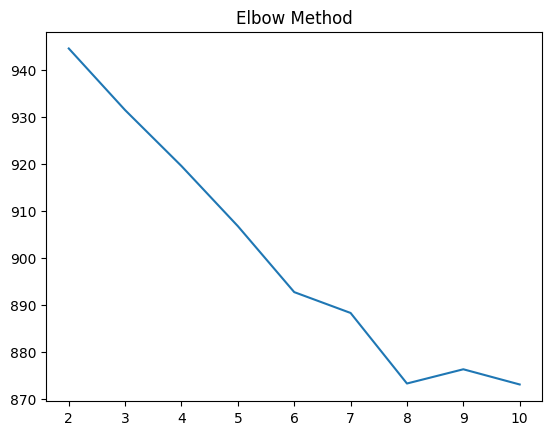

Graph Plotted. Please Analyze and Choose a cluster number based on graph.


Creating Model...


Extracted Topics: 

Topic 0
['titanfall', 'ea', 'linux', 'died', 'legends', 'origin', 'pet', 'sex', 'thumbs', 'loba', 'cat', 'fortnite', 'leave', 'battle', 'play', 'review', 'royale', 'lobas', 'apex', 'mozambique', 'servers', 'ass', 'ape', 'games', 'passes', 'steam', 'game', 'support', 'awards', 'respawn', 'bring', 'removed', 'time', 'finally', 'add', 'duos', 'cheaters', 'friends', 'apesex', 'party', 'kill', 'trash', 'fun', '1010', 'bad', 'gibbys', 'players', 'die', 'recommend', 'bruda', 'remove', 'gender', 'read', 'neutral', 'gay', 'deck', 'hours', 'anticheat', 'day', 'assist', 'pass', 'christs', 'matchmaking', 'balls', 'audio', 'love', 'pretty', 'aim', 'retarded', 'banned', 'trust', 'piece', 'arenas', 'skins', 'launch', 'uninstall', 'garbage', 'warzone', 'hard', 'killed', 'money', 'pathfinder', 'legend', 'cool', 'cancer', 'gameplay', 'played', 'minutes', 'company', 'sanity', 'attracted', '

(KMeans(n_clusters=4, n_init=10, random_state=0),
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 24561 stored elements and shape (1000, 6985)>,
 None)

In [33]:
extract_topics(df_new['Review'])

In [34]:
positive_highs= df_new[
 (df_new['isRecommended'] == 1) &
 (df_new['Hours on Account'] > df_new['Hours on Account'].mean()) &
 (df_new['Users found review helpful'] > df_new['Users found review helpful'].mean())
].copy()

positive_lows = df_new[
 (df_new['isRecommended'] == 1) &
 (df_new['Hours on Account'] < df_new['Hours on Account'].mean()) &
 (df_new['Users found review helpful'] > df_new['Users found review helpful'].mean())
].copy()

negative_highs = df_new[
 (df_new['isRecommended'] == 0) &
 (df_new['Hours on Account'] > df_new['Hours on Account'].mean()) &
 (df_new['Users found review helpful'] > df_new['Users found review helpful'].mean())
].copy()

negative_lows = df_new[
 (df_new['isRecommended'] == 0) &
 (df_new['Hours on Account'] < df_new['Hours on Account'].mean()) &
 (df_new['Users found review helpful'] > df_new['Users found review helpful'].mean())
].copy()

all_positive = df_new[df_new['isRecommended'] == 1].copy()
all_negative = df_new[df_new['isRecommended'] == 0].copy()


Initializing Model...


Inertia Graph for Optimal Cluster Selection



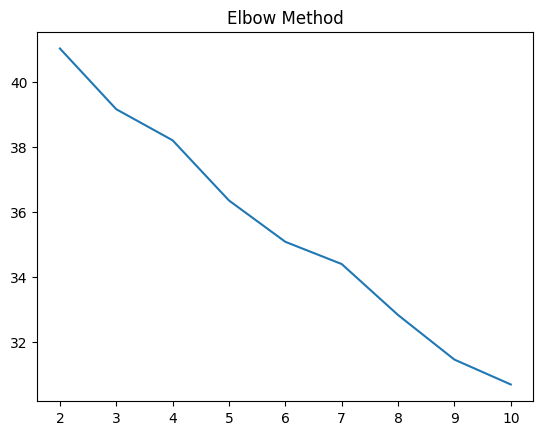

Graph Plotted. Please Analyze and Choose a cluster number based on graph.


Creating Model...


Extracted Topics: 

Topic 0
['minutes', 'raging', 'wraith', 'recommend', 'caustic', 'anxiety', 'disorder', 'breakdown', 'bipolar', 'erections', 'mood', 'relationships', 'swings', 'racism', 'ttv', '1010', 'waiting', 'game', 'squad', 'menu', 'queue', 'main', 'worth', 'wall', '5960', 'dropped', '15', 'spider', 'joined', 'looting', 'waited', 'players', 'bald', 'match', 'spent', 'guy', 'die', 'friendly', 'parkour', 'aggressive', 'hiding', 'movementbased', 'killed', 'difference', 'shotgun', 'sniper', 'traditional', 'camper', 'disliked', 'focused', 'git', 'hit', 'gud', 'gap', 'battlefield', '1000m', 'pubg', 'rng', 'rewards', 'kid', 'bullet', 'building', 'unfair', 'discourages', 'hamsters', 'pick', 'zone', 'putting', 'sweaty', 'camping', 'skill', 'playstyle', 'games', 'single', 'respawn', 'server', 'time', 'apex', 'wipes', 'word', '4k', '3000', '3rd', '1v3', '500', '4th', 'sweep', 'drugs', 'dude', '

(KMeans(n_clusters=6, n_init=10, random_state=0),
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 897 stored elements and shape (46, 665)>,
 None)

In [35]:
extract_topics(positive_highs['Review'])


Initializing Model...


Inertia Graph for Optimal Cluster Selection



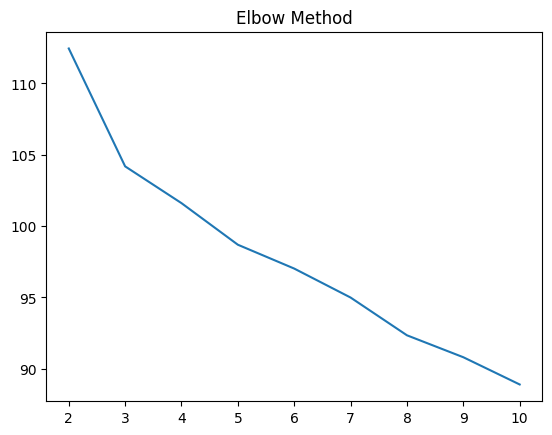

Graph Plotted. Please Analyze and Choose a cluster number based on graph.


Creating Model...


Extracted Topics: 

Topic 0
['pet', 'thumbs', 'cat', 'leave', 'passes', 'awards', 'friends', 'pass', 'rampart', 'passing', 'capybara', 'beautiful', 'steam', '1999', 'zip', '175', '15ounce', '15', '1440p', '14', '13', '12ounce', '121', '12', '11easy', '11', '10inch', '1010', '1000', '02s', 'womans', 'wolfhirschhorn', 'wolffparkinsonwhite', 'wisses', 'wise', 'wisdom', 'wire', 'wipes', 'wiped', 'wine', 'win', 'wilson', 'williams', 'willebrand', 'wife', 'wielded', 'wide', 'white', 'whiskey', 'whipped', 'wheel', 'wet', 'wellsmart', 'wegeners', 'week', 'wedges', 'weave', 'weapons', 'weapon', 'wattsons', 'wattson', 'watson', 'watermelon', 'water', 'watching', 'watch', 'warzone', 'warranted', 'wanna', 'walls', 'waiting', 'wait', 'vortex', 'von', 'voice', 'vodka', 'vocal', 'visuals', 'visual', 'virus', 'virgins', 'videos', 'vices', 'vestibular', 'vertigo', 'veins', 'vein', 'vegetable', 'vast', 'varie

(KMeans(n_clusters=3, n_init=10, random_state=0),
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 2737 stored elements and shape (133, 1702)>,
 None)

In [36]:
extract_topics(positive_lows['Review'])


Initializing Model...


Inertia Graph for Optimal Cluster Selection



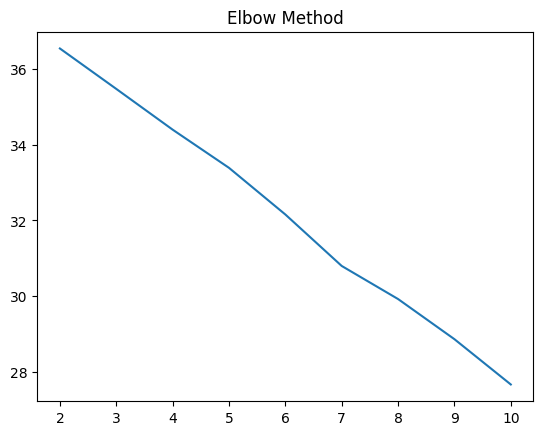

Graph Plotted. Please Analyze and Choose a cluster number based on graph.


Creating Model...


Extracted Topics: 

Topic 0
['trust', 'trash', 'server', 'recommend', 'legends', 'gibbys', 'neutral', 'bruda', 'gender', 'gunplay', 'servers', 'monetization', 'balancing', 'movement', 'hard', 'stuff', 'game', 'terrible', 'developers', 'frustrating', 'fun', 'apex', 'players', 'hours', 'games', 'lazy', 'fake', 'suicidal', 'flaming', '15', 'znce', 'unbalanced', 'inconsistent', '1k', 'asf', 'generic', 'violated', 'resolved', 'transparency', 'slap', 'nuked', 'invest', 'loyalty', 'enjoyed', 'email', 'unacceptable', 'spent', 'details', 'customer', 'cheated', 'treated', 'ban', 'guarantee', 'appealing', 'accountability', 'earespawns', 'mechanics', 'product', 'promises', 'deserves', 'mess', 'expensive', 'pitting', 'loud', 'monstrously', 'laggy', 'jackets', 'modern', 'extortion', 'entertainment', 'public', 'lottery', 'economy', 'sportsmanship', 'mercy', 'discerning', 'digital', 'devoid', 'marvel', 'unr

(KMeans(n_clusters=6, n_init=10, random_state=0),
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 2467 stored elements and shape (41, 1527)>,
 None)

In [37]:
extract_topics(negative_highs['Review'])


Initializing Model...


Inertia Graph for Optimal Cluster Selection



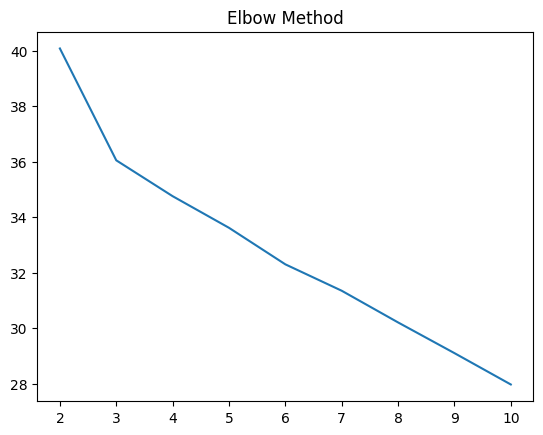

Graph Plotted. Please Analyze and Choose a cluster number based on graph.


Creating Model...


Extracted Topics: 

Topic 0
['game', 'apex', 'play', 'ea', 'season', 'servers', 'playing', 'trash', 'skins', 'players', 'respawn', 'legends', 'issues', 'matchmaking', 'people', 'bikini', 'fun', 'unplayable', 'bad', 'hours', 'time', 'update', 'review', 'money', 'day', 'level', 'games', 'account', 'crashing', 'tournament', 'streamer', 'support', 'decided', 'steam', 'read', 'dementia', 'lobbies', 'spend', 'started', 'hit', 'literally', 'pls', 'china', 'lock', 'region', 'snort', 'cocaine', 'skill', 'love', 'session', 'diamond', 'cheaters', 'issue', 'match', 'gameplay', 'crashed', 'gaming', 'devs', 'player', 'freezes', 'removed', 'played', 'ranked', 'cancer', 'supposed', 'fine', 'addicting', 'unhealthiest', 'communities', 'involved', 'legend', 'pass', 'completely', 'pc', 'gain', 'sad', 'predators', 'friends', 'minute', 'petty', 'penalty', 'abandon', 'heirloom', 'based', '100x', 'weapon', 'solo', 

(KMeans(n_clusters=3, n_init=10, random_state=0),
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 2297 stored elements and shape (48, 1581)>,
 None)

In [38]:
extract_topics(negative_lows['Review'])


Initializing Model...


Inertia Graph for Optimal Cluster Selection



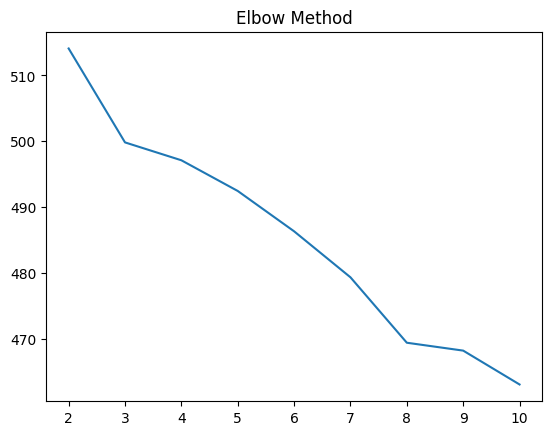

Graph Plotted. Please Analyze and Choose a cluster number based on graph.


Creating Model...


Extracted Topics: 

Topic 0
['solo', 'mode', 'game', 'players', 'friends', 'squads', 'egg', 'personally', 'royales', 'battle', 'newbie', 'eggs', 'components', 'hard', 'gods', 'unrealistic', 'tons', 'apex', 'communication', 'shooter', 'team', '2021', 'saint', 'smash', 'pinging', 'developed', 'tightest', 'opportunity', 'randomness', 'patience', 'imo', 'helps', 'sucks', 'runs', 'randoms', 'royal', 'games', 'offers', 'absolutely', 'squad', 'queue', 'graphics', 'pc', 'mechanics', 'expense', 'gameplays', 'overshadowed', 'practices', 'catering', 'genere', 'renovate', 'managed', 'nailed', 'enjoyment', 'legends', 'eas', 'greedy', 'gameplay', 'metas', 'messyknow', 'succeed', 'app', 'communicate', 'aspects', 'lack', 'core', '3k', 'mess', 'royale', 'shoots', 'misclick', 'pepehappy', '6060', '20th', '19', 'simultaneously', 'playing', 'time', 'odd', 'changing', 'curve', 'monetization', 'accidentally', 'ab

(KMeans(n_clusters=6, n_init=10, random_state=0),
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 10420 stored elements and shape (558, 4030)>,
 None)

In [39]:
extract_topics(all_positive['Review'])


Initializing Model...


Inertia Graph for Optimal Cluster Selection



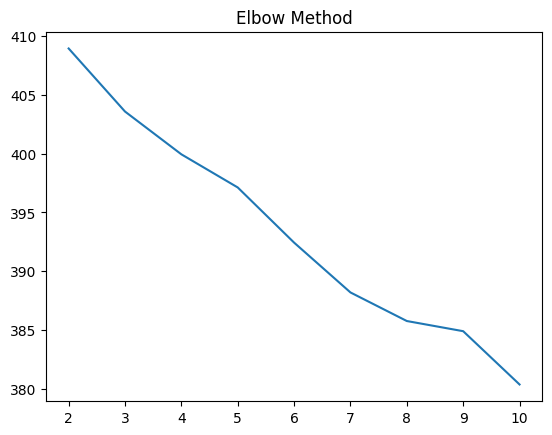

Graph Plotted. Please Analyze and Choose a cluster number based on graph.


Creating Model...


Extracted Topics: 

Topic 0
['game', 'servers', 'play', 'players', 'apex', 'time', 'people', 'matchmaking', 'season', 'playing', 'legends', 'money', 'fun', 'hours', 'cheaters', 'bad', 'respawn', 'games', 'ranked', 'player', 'ea', 'issues', 'terrible', 'aim', 'battle', 'product', 'update', 'received', 'skins', 'played', 'assist', 'level', 'banned', 'controller', 'developers', 'pass', 'worst', 'recommend', 'skill', 'devs', 'day', 'audio', 'friends', 'match', 'love', 'broken', 'worse', 'literally', 'bugs', 'issue', 'server', 'steam', 'garbage', 'care', 'casual', 'crashing', 'base', 'sucks', 'kills', 'real', 'cancer', '20', 'cosmetics', 'running', 'pc', 'spend', 'lot', 'greed', 'movement', 'unplayable', 'fixed', 'started', 'based', 'start', 'reason', 'mode', 'experience', 'gameplay', 'team', 'ruined', 'times', 'account', 'sbmm', 'horrible', 'support', 'seasons', 'absolutely', 'months', 'change',

(KMeans(n_clusters=6, n_init=10, random_state=0),
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 14141 stored elements and shape (442, 4772)>,
 None)

In [40]:
extract_topics(all_negative['Review'])

# Visualization

In [41]:
box_df = df_new[['Hours on Account','isRecommended']].copy()
box_df['isRecommended'] = box_df['isRecommended'].map({0:'Not Recommended',1:'Recommended'})
box_df

Hours on Account    isRecommended
0                  41  Not Recommended
1               18656  Not Recommended
2                  96      Recommended
3                  11      Recommended
4                 166      Recommended
..                ...              ...
995              8195  Not Recommended
996              1057  Not Recommended
997                18  Not Recommended
998              3316      Recommended
999                23  Not Recommended

[1000 rows x 2 columns]

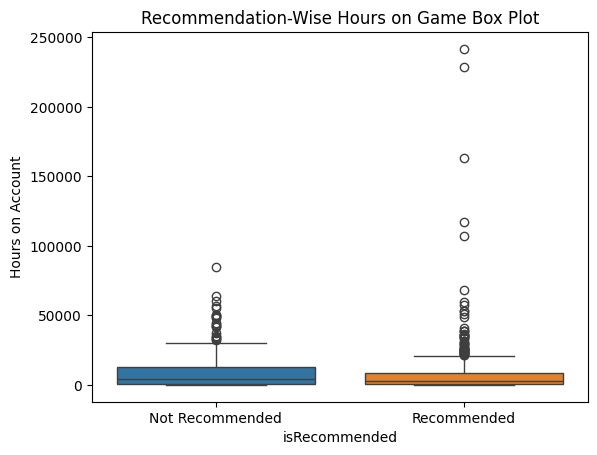

In [42]:
sns.boxplot(data = box_df, x = 'isRecommended', y = 'Hours on Account', hue = 'isRecommended')
plt.title('Recommendation-Wise Hours on Game Box Plot')
plt.show()

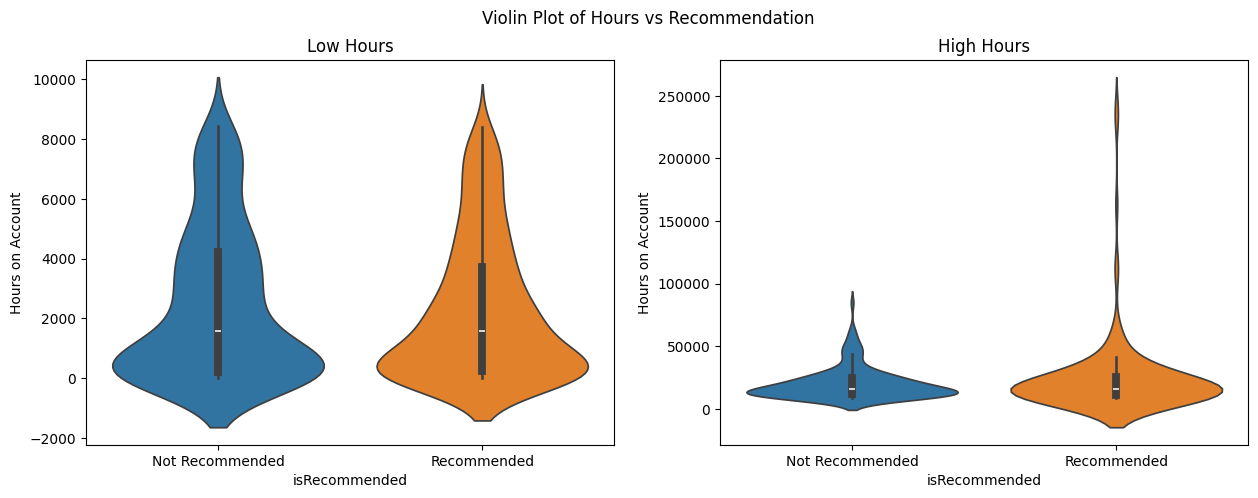

In [43]:
high_hours_df = box_df[box_df['Hours on Account'] > box_df['Hours on Account'].mean()].copy()
low_hours_df = box_df[box_df['Hours on Account'] <= box_df['Hours on Account'].mean()].copy()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

fig.suptitle('Violin Plot of Hours vs Recommendation')

sns.violinplot(low_hours_df[['Hours on Account','isRecommended']], x = 'isRecommended', y = 'Hours on Account', hue = 'isRecommended', ax = axs[0])
axs[0].set_title('Low Hours')

sns.violinplot(high_hours_df[['Hours on Account','isRecommended']], x = 'isRecommended', y = 'Hours on Account', hue = 'isRecommended', ax = axs[1])
axs[1].set_title('High Hours')

plt.show()

# I wanna see if the hours on the game affects whether the player would recommend it or not?

# Violin plot
# Left: Low Hours
# Right: High Hours

In [44]:
box_df

Hours on Account    isRecommended
0                  41  Not Recommended
1               18656  Not Recommended
2                  96      Recommended
3                  11      Recommended
4                 166      Recommended
..                ...              ...
995              8195  Not Recommended
996              1057  Not Recommended
997                18  Not Recommended
998              3316      Recommended
999                23  Not Recommended

[1000 rows x 2 columns]

In [45]:
box_df['Hours on Account'].describe()

count      1000.000000
mean       8478.611000
std       16197.627037
min           1.000000
25%         644.500000
50%        3609.500000
75%       10376.250000
max      241730.000000
Name: Hours on Account, dtype: float64

<Axes: >

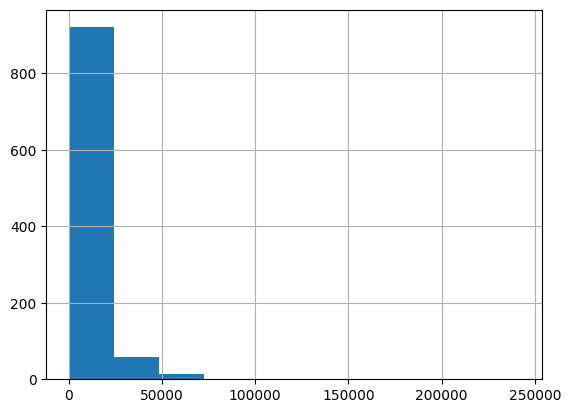

In [46]:
box_df['Hours on Account'].hist()

In [47]:
df_new.head()

Author                                             Review  \
0                 Kaladin  2 10 dollar battle passes per season\n\nTitanf...   
1                    KEVE  Now with the new battle pass system, I'm delet...   
2            ⛧ M♱ropele ⛧  At least you don't have to build an apartment ...   
3  to infinity and beyond                       Finally I can remove Origin.   
4      chelovek bez vkusa  Finally here\n\nIt launches without Origin...\...   

   # of Comments  Products  Hours on Account  isRecommended  \
0              0       228                41              0   
1             78        42             18656              0   
2             54       655                96              1   
3              0         0                11              1   
4             35       295               166              1   

   Users found review funny  Users found review helpful  Community Awards  
0                       133                        3796               178  
1                        85                        4370               186  
2                      2017                        3089               500  
3                       634                        1770               103  
4                        91                        2109                49

In [48]:
numeric_df = df_new.select_dtypes(exclude = 'object')
column_order = [col for col in numeric_df.columns if col != 'isRecommended'] + ['isRecommended']
numeric_df = numeric_df[column_order]
numeric_df['isRecommended'] = numeric_df['isRecommended'].map({0:'Not Recommended',1:'Recommended'})
numeric_df

# of Comments  Products  Hours on Account  Users found review funny  \
0                0       228                41                       133   
1               78        42             18656                        85   
2               54       655                96                      2017   
3                0         0                11                       634   
4               35       295               166                        91   
..             ...       ...               ...                       ...   
995              0        74              8195                         1   
996              0       347              1057                         0   
997              0         0                18                         0   
998              0       162              3316                         0   
999              0         0                23                        13   

     Users found review helpful  Community Awards    isRecommended  
0                          3796               178  Not Recommended  
1                          4370               186  Not Recommended  
2                          3089               500      Recommended  
3                          1770               103      Recommended  
4                          2109                49      Recommended  
..                          ...               ...              ...  
995                          14                 0  Not Recommended  
996                          11                 0  Not Recommended  
997                          24                 0  Not Recommended  
998                           7                 1      Recommended  
999                          10                 0  Not Recommended  

[1000 rows x 7 columns]

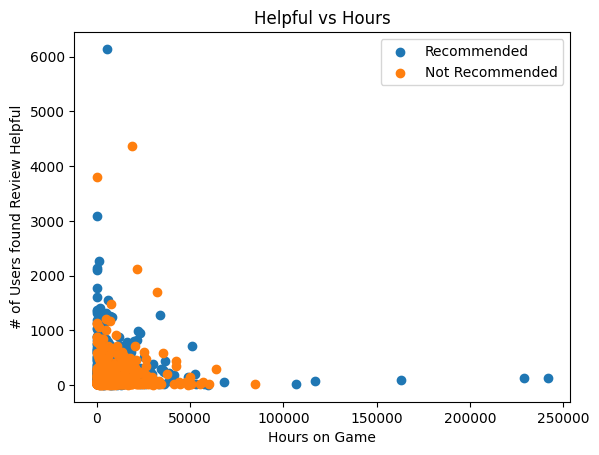

In [49]:
fig, ax = plt.subplots()

ax.scatter(
    data = numeric_df[numeric_df['isRecommended'] == 'Recommended'],
    y = 'Users found review helpful', 
    x = 'Hours on Account',
    label = 'Recommended'
)

ax.scatter(
    data = numeric_df[numeric_df['isRecommended'] == 'Not Recommended'],
    y = 'Users found review helpful', 
    x = 'Hours on Account',
    label = 'Not Recommended'
)

ax.set_title('Helpful vs Hours')
ax.set_ylabel('# of Users found Review Helpful')
ax.set_xlabel('Hours on Game')

plt.legend()
plt.show()

In [50]:
numeric_df[numeric_df['isRecommended'] == 'Not Recommended']['Hours on Account'].apply(np.log)

0      3.713572
1      9.833923
7      9.966368
8      8.961751
9      9.773550
         ...   
994    7.966933
995    9.011279
996    6.963190
997    2.890372
999    3.135494
Name: Hours on Account, Length: 442, dtype: float64

In [51]:
numeric_df[numeric_df['isRecommended'] == 'Not Recommended'][['Users found review helpful','Hours on Account']].apply(np.log)

Users found review helpful  Hours on Account
0                      8.241703          3.713572
1                      8.382518          9.833923
7                      7.659171          9.966368
8                      7.304516          8.961751
9                      6.184149          9.773550
..                          ...               ...
994                    1.945910          7.966933
995                    2.639057          9.011279
996                    2.397895          6.963190
997                    3.178054          2.890372
999                    2.302585          3.135494

[442 rows x 2 columns]

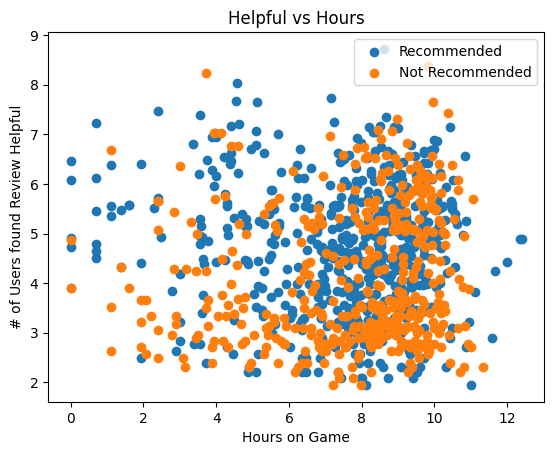

In [52]:
fig, ax = plt.subplots()

ax.scatter(
    data = numeric_df[numeric_df['isRecommended'] == 'Recommended'][['Users found review helpful','Hours on Account']].apply(np.log),
    y = 'Users found review helpful',
    x = 'Hours on Account',
    label = 'Recommended'
)

ax.scatter(
    data = numeric_df[numeric_df['isRecommended'] == 'Not Recommended'][['Users found review helpful','Hours on Account']].apply(np.log),
    y = 'Users found review helpful',
    x = 'Hours on Account',
    label = 'Not Recommended'
)

ax.set_title('Helpful vs Hours')
ax.set_ylabel('# of Users found Review Helpful')
ax.set_xlabel('Hours on Game')

plt.legend()
plt.show()

In [53]:
numeric_df[['Products', 'Hours on Account']].apply(np.log1p)

Products  Hours on Account
0    5.433722          3.737670
1    3.761200          9.833977
2    6.486161          4.574711
3    0.000000          2.484907
4    5.690359          5.117994
..        ...               ...
995  4.317488          9.011402
996  5.852202          6.964136
997  0.000000          2.944439
998  5.093750          8.106816
999  0.000000          3.178054

[1000 rows x 2 columns]

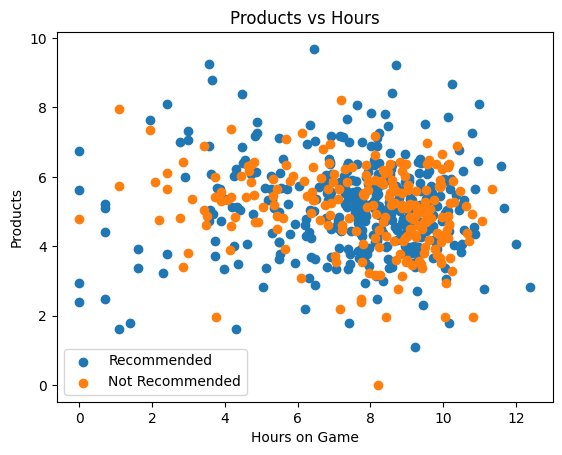

In [54]:
fig, ax = plt.subplots()

ax.scatter(
    data = numeric_df[numeric_df['isRecommended'] == 'Recommended'][['Products', 'Hours on Account']].apply(np.log),
    y = 'Products', 
    x = 'Hours on Account',
    label = 'Recommended'
)

ax.scatter(
    data = numeric_df[numeric_df['isRecommended'] == 'Not Recommended'][['Products', 'Hours on Account']].apply(np.log),
    y = 'Products', 
    x = 'Hours on Account',
    label = 'Not Recommended'
)

ax.set_title('Products vs Hours')
ax.set_ylabel('Products')
ax.set_xlabel('Hours on Game')

plt.legend()
plt.show()

### Categorizing Reviews

In [55]:
df_new.head()

Author                                             Review  \
0                 Kaladin  2 10 dollar battle passes per season\n\nTitanf...   
1                    KEVE  Now with the new battle pass system, I'm delet...   
2            ⛧ M♱ropele ⛧  At least you don't have to build an apartment ...   
3  to infinity and beyond                       Finally I can remove Origin.   
4      chelovek bez vkusa  Finally here\n\nIt launches without Origin...\...   

   # of Comments  Products  Hours on Account  isRecommended  \
0              0       228                41              0   
1             78        42             18656              0   
2             54       655                96              1   
3              0         0                11              1   
4             35       295               166              1   

   Users found review funny  Users found review helpful  Community Awards  
0                       133                        3796               178  
1                        85                        4370               186  
2                      2017                        3089               500  
3                       634                        1770               103  
4                        91                        2109                49

# KMeans


Initializing Model...


Inertia Graph for Optimal Cluster Selection



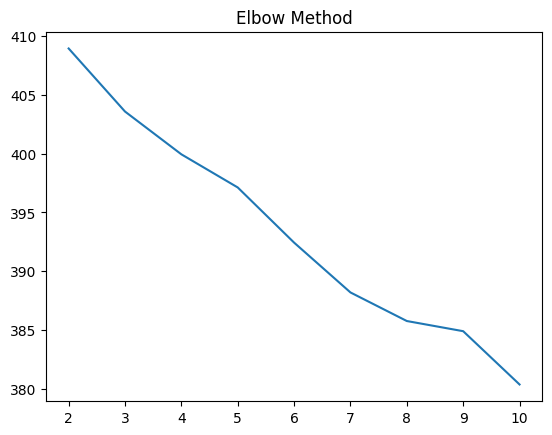

Graph Plotted. Please Analyze and Choose a cluster number based on graph.


Creating Model...


Extracted Topics: 

Topic 0
['titanfall', 'died', 'killed', 'play', 'slop', 'crap', 'purchase', 'battle', 'bring', 'original', 'reminder', 'john', 'smh', 'royale', 'killing', 'absolute', 'worth', 'die', 'walk', 'piece', 'passes', 'dollar', 'ea', 'fun', 'linux', 'support', 'season', 'yesterdays', 'yesterday', 'yellow', 'yeast', 'yearat', 'yeahthey', 'yeahh', 'yeah', 'yards', 'zombify', 'yall', 'ya', 'xd', 'xbox', 'wtf', 'wrote', 'wrong', 'written', 'writing', 'write', 'wretches', 'wraiths', 'wraithnaruto', 'wraith', 'wow', 'wound', 'wouldve', 'worthy', 'worthwhile', 'worst', 'worshipers', 'worsereworked', 'worsend', 'worsen', 'worse', 'worry', 'worried', 'worlds', 'worldreal', 'word', 'wood', 'wonders', 'wonderland', 'wondering', 'wonderful', 'wondered', 'woman', 'wl', 'witness', 'withthats', 'witcher', 'wishes', 'wished', 'wise', 'wiping', 'wipe', 'wins', 'winrate', 'wingman', 'windows', 'wi

In [56]:
negative_model, negative_document_X, negative_vocab = extract_topics(all_negative['Review'], getModel = True)

In [57]:
negative_topics = {
    0: 'Comparison to Titanfall',
    1: 'OS Support',
    2: 'Battlepass and Microtransactions',
    3: 'Server and Matchmaking Issues',
    4: 'Unfair/High Level Opponents and Cheaters',
}

In [58]:
all_negative['Category'] = negative_model.predict(negative_document_X)
all_negative['Category'] = all_negative['Category'].map(negative_topics)
all_negative

Author                                             Review  \
0              Kaladin  2 10 dollar battle passes per season\n\nTitanf...   
1                 KEVE  Now with the new battle pass system, I'm delet...   
7              🐾Gizmo🐾  We don't have a cheater problem.\nOk we do hav...   
8            Blödhgarm  I've got nearly 3k hours in this game, most of...   
9    DeeDee MegaDooDoo  I've been playing this game since release, and...   
..                 ...                                                ...   
994       TTV Tarquar_  ♥♥♥♥ GAME NEEDS A SOLO MODE. ALL MY TEAMATES A...   
995     Mayano Top Gun                                       GAME NGENTOD   
996             Dubinn  Used to love it, now look at what they did to ...   
997              Fiery  You removed linux support? AI cheats basically...   
999               BOOF  This game gave me:\n\n· Acne\n· AIDS\n· Allerg...   

     # of Comments  Products  Hours on Account  isRecommended  \
0                0       228                41              0   
1               78        42             18656              0   
7               48       508             21298              0   
8                0         0              7799              0   
9               16         0             17563              0   
..             ...       ...               ...            ...   
994              3        25              2884              0   
995              0        74              8195              0   
996              0       347              1057              0   
997              0         0                18              0   
999              0         0                23              0   

     Users found review funny  Users found review helpful  Community Awards  \
0                         133                        3796               178   
1                          85                        4370               186   
7                          85                        2120               211   
8                          28                        1487               247   
9                          21                         485                59   
..                        ...                         ...               ...   
994                         1                           7                 0   
995                         1                          14                 0   
996                         0                          11                 0   
997                         0                          24                 0   
999                        13                          10                 0   

                             Category  
0             Comparison to Titanfall  
1    Battlepass and Microtransactions  
7                          OS Support  
8       Server and Matchmaking Issues  
9       Server and Matchmaking Issues  
..                                ...  
994     Server and Matchmaking Issues  
995     Server and Matchmaking Issues  
996     Server and Matchmaking Issues  
997                        OS Support  
999     Server and Matchmaking Issues  

[442 rows x 10 columns]

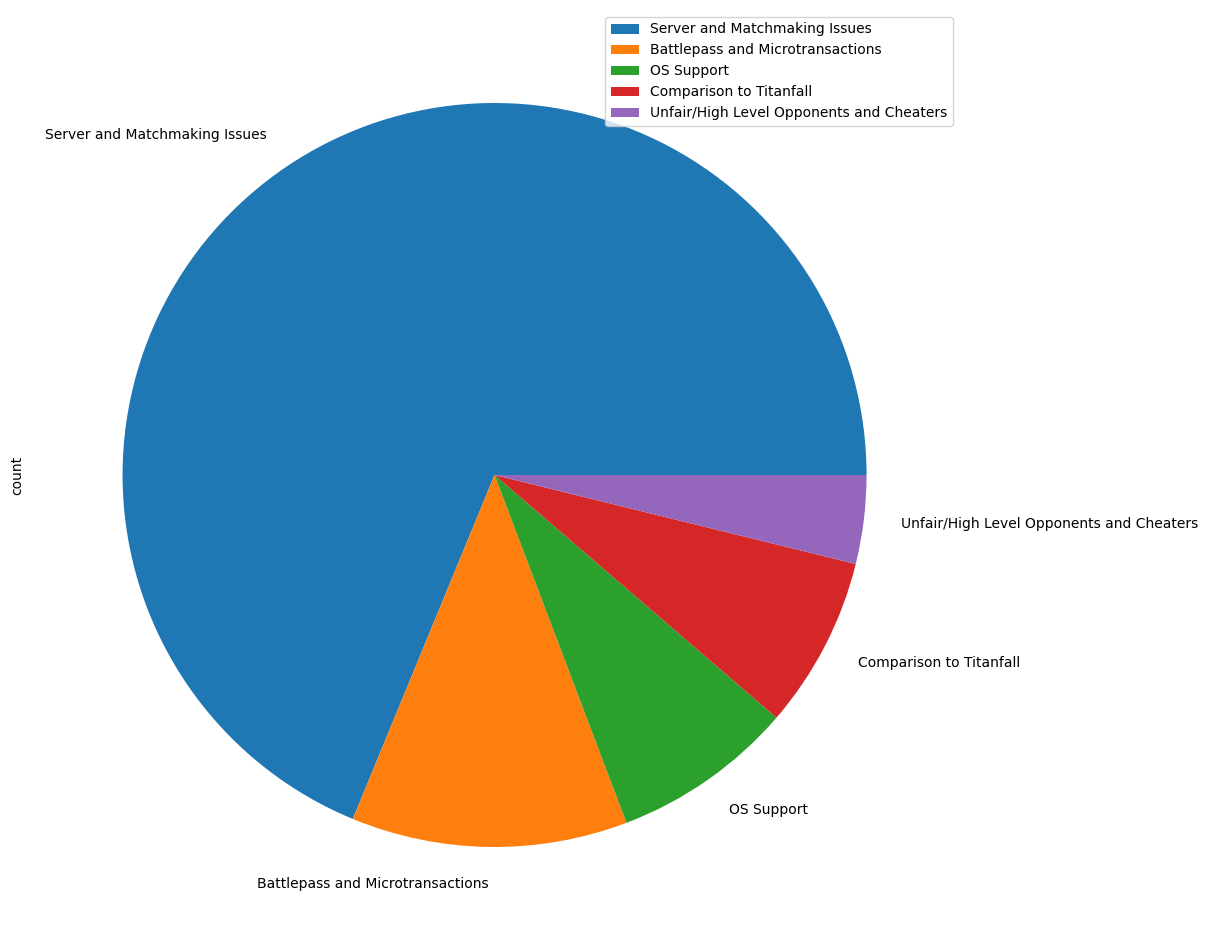

In [59]:
(
    all_negative['Category']
    .value_counts()
    .reset_index()
    .set_index('Category')
    .plot(
            kind = 'pie',
            y = 'count',
            figsize = (12, 15)
        )
)
plt.legend(loc = 'upper right')
plt.show()


Initializing Model...


Inertia Graph for Optimal Cluster Selection



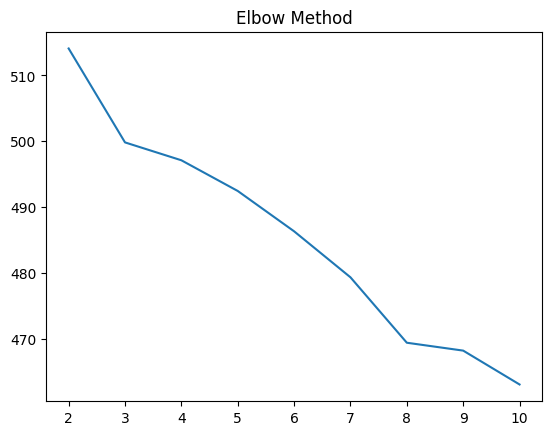

Graph Plotted. Please Analyze and Choose a cluster number based on graph.


Creating Model...


Extracted Topics: 

Topic 0
['win', 'apartment', 'complex', 'build', 'apex', 'architect', 'fun', 'octane', 'legend', 'zika', 'zest', 'zampella', 'zaidi', 'yucky', 'youtube', 'yonder', 'yolk', '11easy', '15ounce', '1510', '150', '15', '1440p', '14', '13inch', '1300', '13', '12ounce', '12k', '12673517612345', '1250', '121', 'yo', 'xbox', 'wrote', 'wrong', 'writing', 'wraiths', 'wraith', 'worthwhile', 'worth', 'worstrun', 'worst', 'worse', 'worry', 'worlds', 'worldbuilding', 'word', 'woowoo', 'wooooow', 'woohoo', 'wooden', 'wondering', 'wonderfully', 'wonderful', 'womans', 'wolfhirschhorn', 'wolffparkinsonwhite', 'wisses', 'wishing', 'wise', 'wisdom', 'wire', 'wiping', 'wipes', 'wiped', 'wipe', 'wins', 'winninggetting', 'winning', 'winner', 'wink', 'wingman', 'wine', 'window', 'wilson', 'williams', 'willebrand', 'wild', 'wife', 'wielded', 'widespread', 'wide', 'white', 'whiskey', 'whisked', 'wh

In [60]:
positive_model, positive_document_X, positive_vocab = extract_topics(all_positive['Review'], getModel = True)

In [61]:
positive_topics = {
    0: 'Unlike Fortnite',
    1: 'Emotes and Friends',
    2: 'Removal of Origin Launcher'
}

In [62]:
all_positive['Category'] = positive_model.predict(positive_document_X)
all_positive['Category'] = all_positive['Category'].map(positive_topics)
all_positive

Author  \
2              ⛧ M♱ropele ⛧   
3    to infinity and beyond   
4        chelovek bez vkusa   
5                    Shanks   
6                     azure   
..                      ...   
978         L a s w i n k a   
979           Rest.N.Pieces   
985                Dayonica   
990                  Sonder   
998                 ZenTrix   

                                                Review  # of Comments  \
2    At least you don't have to build an apartment ...             54   
3                         Finally I can remove Origin.              0   
4    Finally here\n\nIt launches without Origin...\...             35   
5                                     uninstall origin              0   
6    doesnt launch with origin\n\nedit: easy anti-c...            117   
..                                                 ...            ...   
978  I will leave the cat here, so that everybody w...              0   
979  Product received for free\n\nits super duper f...              0   
985  Buff Loba pls))0 (Posted 20 July, 2021.)\n\nIT...              0   
990  I had an entire family, went through a divorce...              1   
998  You accidentally fall off a cliff while trying...              0   

     Products  Hours on Account  isRecommended  Users found review funny  \
2         655                96              1                      2017   
3           0                11              1                       634   
4         295               166              1                        91   
5           0               161              1                       281   
6         195              5460              1                       915   
..        ...               ...            ...                       ...   
978        81              4183              1                         4   
979         0              8417              1                         4   
985        85             25933              1                         5   
990       562              5345              1                        10   
998       162              3316              1                         0   

     Users found review helpful  Community Awards                    Category  
2                          3089               500             Unlike Fortnite  
3                          1770               103  Removal of Origin Launcher  
4                          2109                49  Removal of Origin Launcher  
5                          1180                64  Removal of Origin Launcher  
6                          6142               355  Removal of Origin Launcher  
..                          ...               ...                         ...  
978                          71                11          Emotes and Friends  
979                          29                 3  Removal of Origin Launcher  
985                          22                 1  Removal of Origin Launcher  
990                          10                 3  Removal of Origin Launcher  
998                           7                 1  Removal of Origin Launcher  

[558 rows x 10 columns]

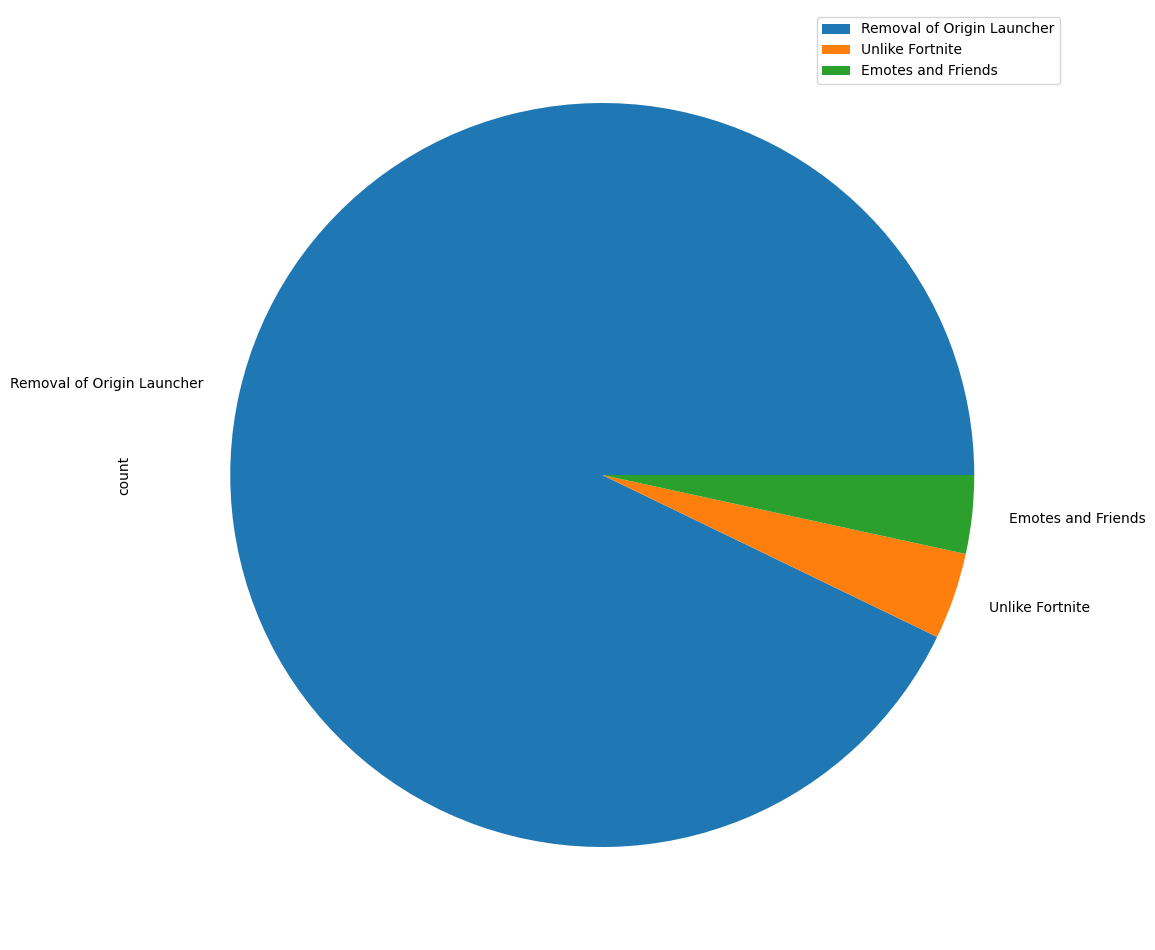

In [63]:
(
    all_positive['Category']
    .value_counts()
    .reset_index()
    .set_index('Category')
    .plot(
            kind = 'pie',
            y = 'count',
            figsize = (12, 15)
        )
)
plt.legend(loc = 'upper right')
plt.show()

# LDA

In [ ]:
# Download stopwords from nltk only once
# import nltk

# nltk.download('stopwords')

In [85]:
from nltk.corpus import stopwords
import regex as re

def tokenize(text: str) -> list[str]:
    # Clean text by removing non-alphanumeric characters
    text = re.sub('[^a-zA-Z0-9 ]', '', text)
    
    # Split words into non-stopword lowercase words
    texts = [word for word in text.lower().split() if word not in stopwords.words('english')]

    return texts
    

In [89]:
negative_gensim_docs = [tokenize(doc) for doc in all_negative['Review'].tolist()]

In [90]:
from gensim.corpora.dictionary import Dictionary

negative_dictionary = Dictionary(negative_gensim_docs)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.matutils import Sparse2Corpus

# negative_corpus = Sparse2Corpus(negative_document_X) # Corpus may be implemented incorrectly
negative_lda = LdaModel(negative_corpus, num_topics = 5, id2word = negative_dictionary.id2token)


In [227]:
negative_lda.print_topics()

[(0,
  '0.005*"3strikes" + 0.005*"actors" + 0.004*"arenas" + 0.004*"3stacks" + 0.003*"10000" + 0.003*"aged" + 0.003*"1000s" + 0.003*"announcement" + 0.003*"400" + 0.003*"55th"'),
 (1,
  '0.004*"600" + 0.004*"abilitys" + 0.004*"200kg" + 0.003*"age" + 0.003*"1m" + 0.003*"40h" + 0.003*"46" + 0.003*"300000" + 0.003*"14s" + 0.003*"afterthoughts"'),
 (2,
  '0.005*"aforementioned" + 0.005*"360" + 0.005*"3600xt" + 0.004*"11" + 0.004*"ape" + 0.004*"115" + 0.004*"agenda" + 0.004*"10010" + 0.004*"60eur" + 0.004*"773"'),
 (3,
  '0.005*"accessibility" + 0.005*"10010" + 0.004*"allgamesweslapourlogoonturnstohotdookie" + 0.004*"accessing" + 0.004*"abusers" + 0.004*"26" + 0.004*"amazing" + 0.003*"910" + 0.003*"410x" + 0.003*"accomplished"'),
 (4,
  '0.006*"05" + 0.004*"accessible" + 0.004*"14k" + 0.004*"aimzz" + 0.004*"accepteable" + 0.004*"45" + 0.003*"apexand" + 0.003*"5050" + 0.003*"animation" + 0.003*"89kdr"')]

In [228]:
negative_corpus

In [229]:
negative_coherence = CoherenceModel(
    model = negative_lda,
    texts = negative_corpus,
    corpus = negative_corpus
)

In [ ]:
# negative_coherence.get_coherence()

AttributeError: 'dict' object has no attribute 'id2token'

# Evaluation

In [ ]:
silhouette_negative = silhouette_score(negative_document_X, negative_model.predict(negative_document_X))

silhouette_positive = silhouette_score(positive_document_X, positive_model.predict(positive_document_X))

print('Silhouette Score for Negative Review Topics: {}'.format(silhouette_negative))
print('Silhouette Score for Positive Review Topics: {}'.format(silhouette_positive))

Silhouette Score for Negative Review Topics: 0.03492910777712639
Silhouette Score for Positive Review Topics: 0.05350337684485115


To Do:
- Try applying LDA topic extraction
- Evaluate Topic Segregation/Clustering
- Apply Notes and Comments about code